In [3]:
%load_ext autoreload
%autoreload 2


import time
import psutil
import dask.distributed
import rioxarray
import numpy as np
import xarray as xr
from pystac_client import Client
import matplotlib.pyplot as plt
import pandas as pd 
from sdc_utilities import get_alias_band, load_product_ts

# silence warning (not recommended during development)
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Change the size of the figures displayed in the notebooks: units are inches, order is (width, height).
plt.rcParams['figure.figsize'] = (16,8)  

# Initiate Dask Env
client = dask.distributed.Client()
catalog = Client.open("https://explorer.swissdatacube.org/stac")

# display(client)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# %load "config_cell.txt"
# Configuration

product = 'landsat_ot_c2_l2'
measurements = ['QA_PIXEL', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5']
aliases = ['QA_PIXEL', 'blue', 'green', 'red', 'nir']  # you can also provide only the aliases and get the measurements with:
# measurements, aliases = get_alias_band(aliases)
# to make your live easier you can manually replace the measurements variable by 
# one of their aliases (if available):

longitude = (7.127, 7.199)
latitude = (46.773, 46.816)
crs = 'epsg:4326'

time = ('2013-03-22', '2013-07-31')
# the following date formats are also valid:
# time = ('2000-01-01', '2001-12-31')
# time=('2000-01', '2001-12')
# time=('2000', '2001')

# You can use an UTM zone according to the DataCube System.
# We prefer not to use this, instead specifying SwissGrid (epsg:2056).
# output_crs = 'epsg:2056'

output_crs = 'epsg:2056'
resolution = -30.0, 30.0

# These are the pixel classifications for Sentinel (SCL) and Landsat (QA_PIXEL); 
# you can use values to mask out values that belong to certain classes

###################################
# SCL categories:                 #
#   0 - no data                   #
#   1 - saturated or defective    #
#   2 - dark area pixels          #
#   3 - cloud_shadows             #
#   4 * vegetation                #
#   5 * not vegetated             #
#   6 * water                     #
#   7 * unclassified              #
#   8 - cloud medium probability  #
#   9 - cloud high probability    #
#  10 - thin cirrus               #
#  11 * snow                      #
###################################

# Check for more detailed information: 
# - Landsat 8/9 (OLI/TIRS), Page 19:
# https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/media/files/LSDS-1619_Landsat8-9-Collection2-Level2-Science-Product-Guide-v6.pdf
# - Landsat 7 (ETM+), Page 15:
# https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/media/files/LSDS-1337_Landsat7ETM-C2-L2-DFCB-v6.pdf
# - Landsat 4,5 (TM), Page 18:
# https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/LSDS-1415_Landsat4-5-TM-C2-L1-DFCB-v3.pdf

#############################################
# QA_PIXEL BITS : CATEGORIES                #
#    0 : Fill                               #
#    1 : Clear                              #
#    2 : Water                              #
#    3 : Cloud shadow                       #
#    4 : Snow                               #
#    5 : Cloud                              #
#   10 : Terrain occlusion (Landsat 8 only) #
#############################################

chunks = {"x": 2048, "y": 2048, "time": 1}  # 2048 values are OK with ~21Gb memory available



In [13]:
dataset_in = load_product_ts(catalog = catalog,
                          product = product,
                          time = time,
                          longitude = longitude,
                          latitude = latitude,
                          measurements = measurements,
                          output_crs = output_crs,
                          resolution = resolution,
                          rename = True,               # This will overwrite the band names with the aliases names ...
                          alias_names = aliases,        # ... that need to be specified here in that case.
                          )

In [14]:
dataset_in

<xarray.Dataset> Size: 15MB
Dimensions:      (y: 161, x: 185, time: 26)
Coordinates:
  * y            (y) float64 1kB 1.185e+06 1.185e+06 ... 1.18e+06 1.18e+06
  * x            (x) float64 1kB 2.576e+06 2.576e+06 ... 2.582e+06 2.582e+06
    spatial_ref  int32 4B 2056
  * time         (time) datetime64[ns] 208B 2013-03-22T10:22:06 ... 2013-07-3...
Data variables:
    QA_PIXEL     (time, y, x) float32 3MB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    blue         (time, y, x) float32 3MB nan nan nan nan ... nan nan nan nan
    green        (time, y, x) float32 3MB nan nan nan nan ... nan nan nan nan
    red          (time, y, x) float32 3MB nan nan nan nan ... nan nan nan nan
    nir          (time, y, x) float32 3MB nan nan nan nan ... nan nan nan nan

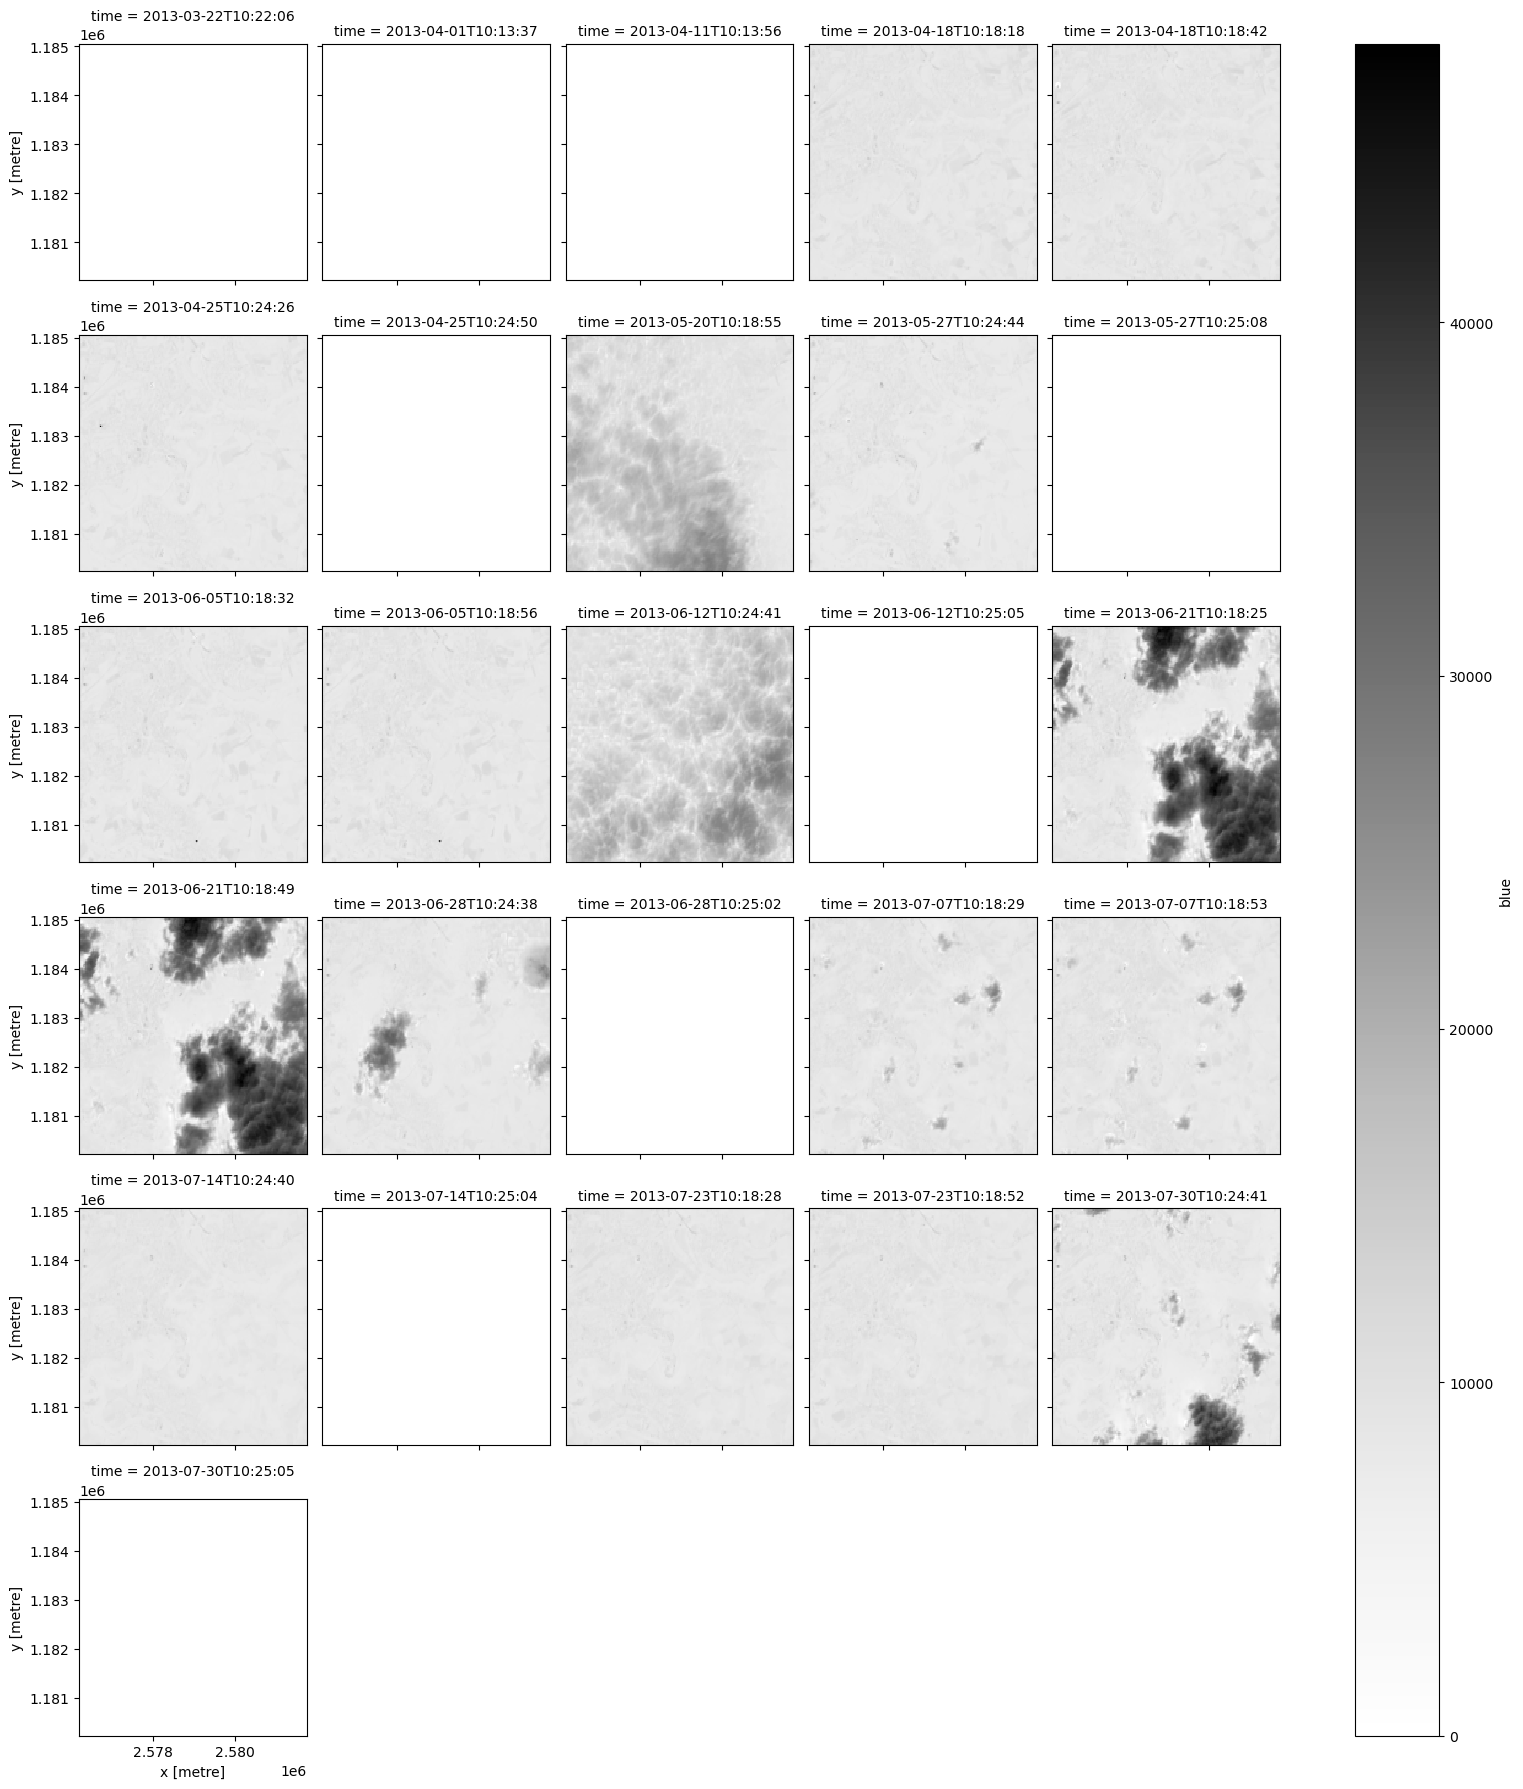

In [15]:
# plot the xarray.Dataset to get an overview of the different scenes along the time axis
dataset_in.blue.plot(col='time', col_wrap=5, cmap='Greys', vmin=0)

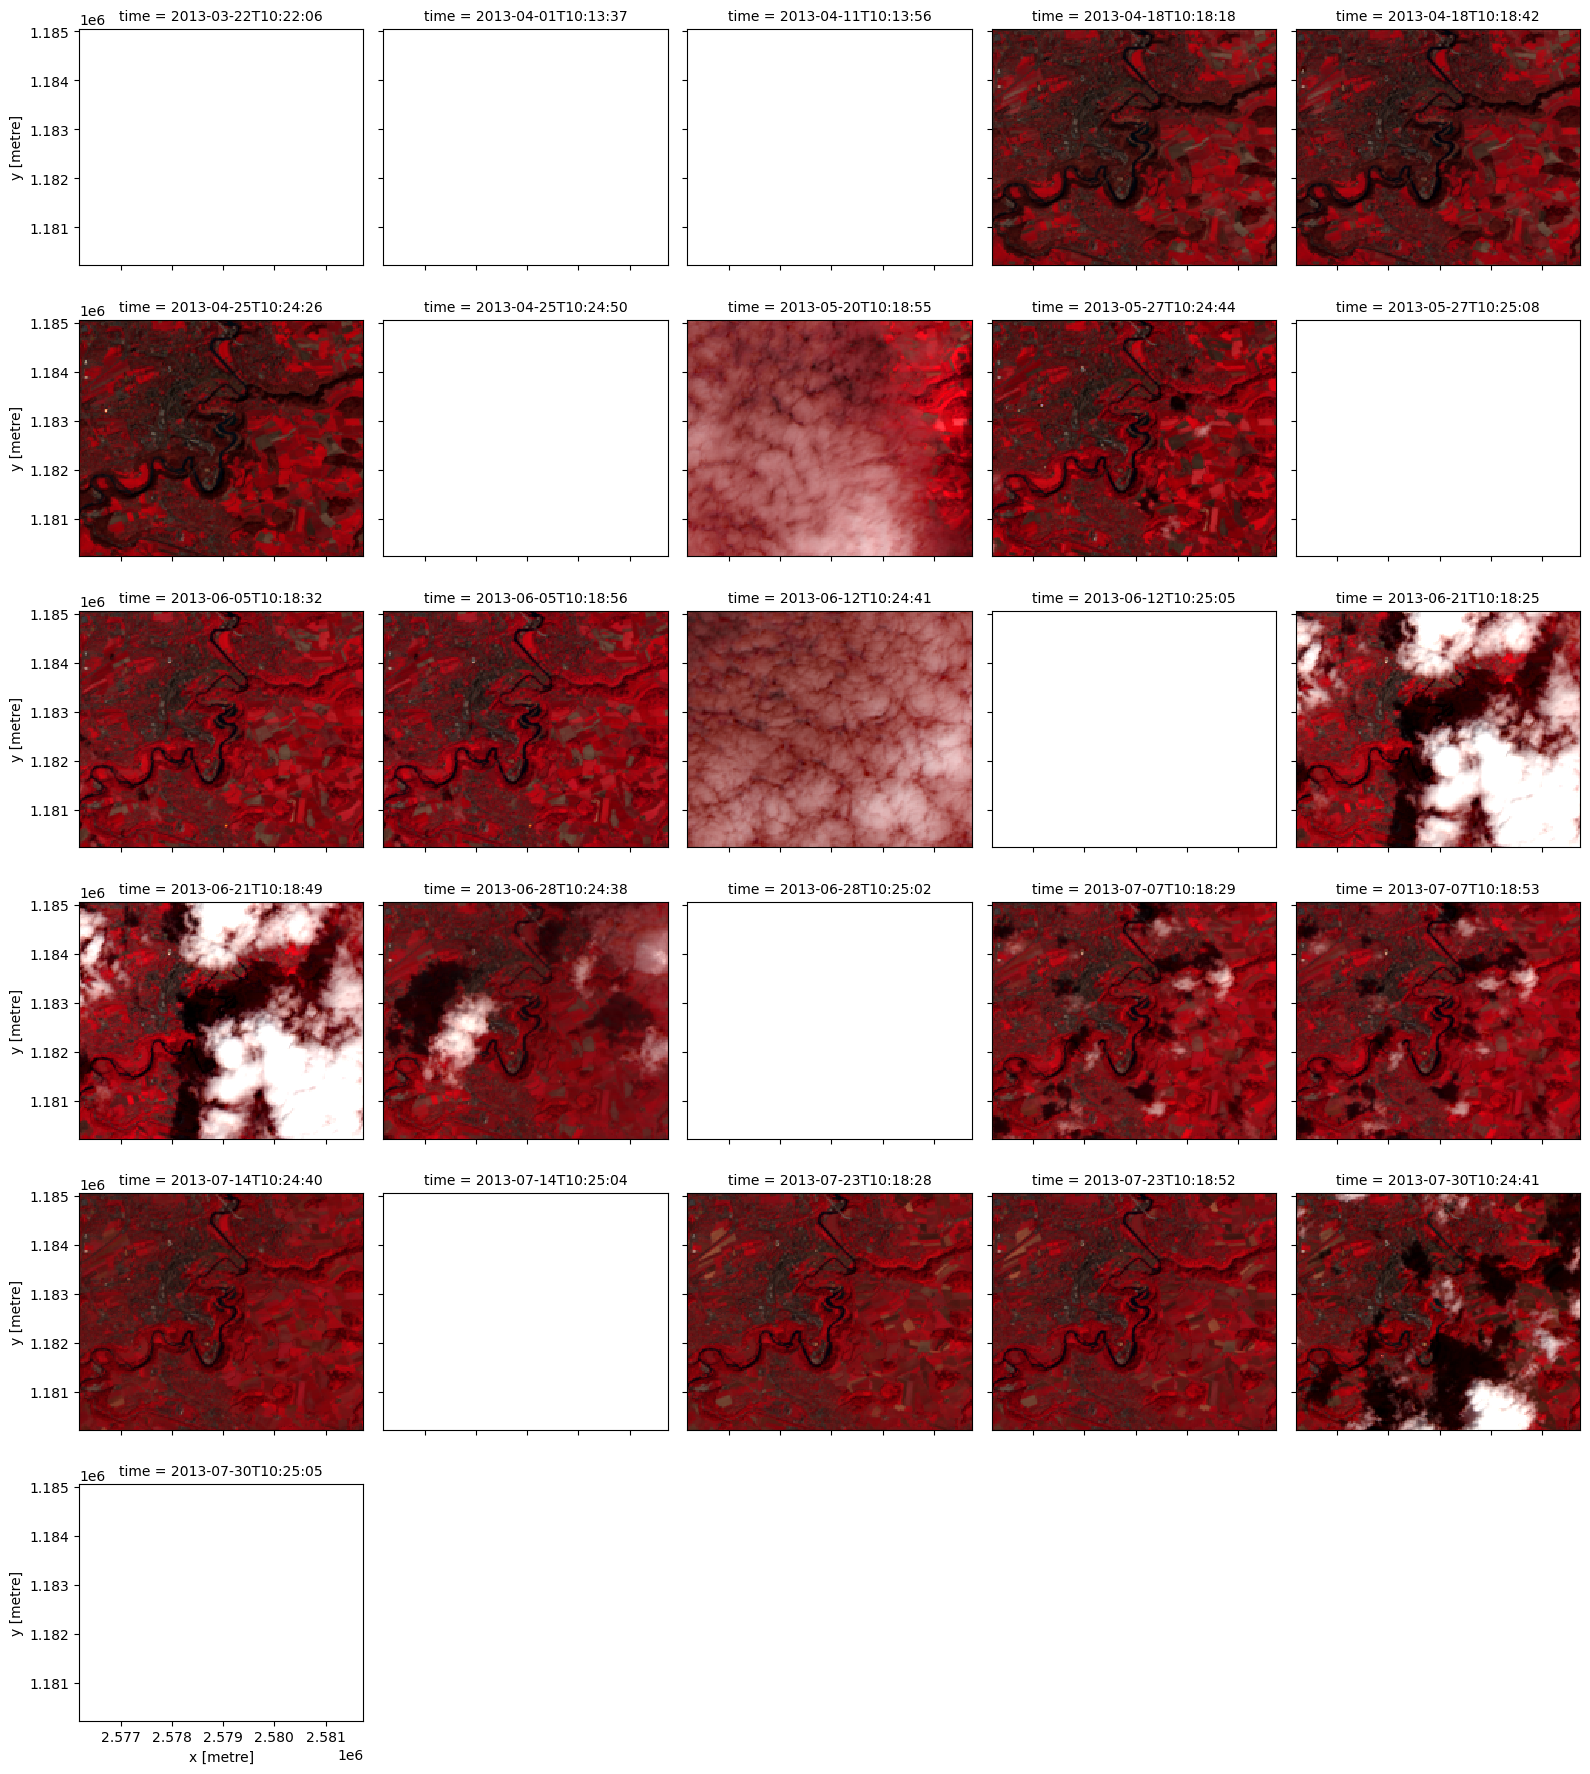

In [16]:
# Let's plot composites in False color (nir, red, green)
dataset_in[['nir','red', 'green']].to_array().plot.imshow(col='time',col_wrap=5, robust=True)